

# Full Star-TREX pipeline

## Introduction

### Input

### The steps

### Output



In [2]:
# Load packages
import sys
import os
from pathlib import Path
sys.path.insert(1, os.path.abspath('..'))

In [3]:
#Define working directory:
work_dir = "/Users/leonievb/Library/CloudStorage/OneDrive-Personal/Postdoc/Data/test/"
scheme_path = "/Users/leonievb/anaconda3/envs/starfish/lib/python3.7/site-packages/starfish/spacetx_format/schema/"

## Preparation for starfish

In [3]:
# Create or load codebook
# Create a codebook 
code_path = os.path.join(work_dir, "meta/geneIDs.csv")
key_path = os.path.join(work_dir, "meta/key.csv")
codebook_path = os.path.join(work_dir, "structured_out/codebook.json") #or None
n_channels = 4
n_rounds = 2
trim = 2

from src.codebooker import create_codebook

codebook = create_codebook(code_path, key_path, n_channels, n_rounds, codebook_path, two_bases_code=True, trim = 2)

Alternatively, load an already existing codebook

In [12]:
#codebook_path = os.path.join(work_dir, "structured_out/codebook.json")
#from src.codebooker import load_codebook
#codebook = load_codebook(codebook_path)

Check out the codebook

In [4]:
codebook

(<xarray.Codebook (target: 4, r: 2, c: 4)>
 array([[[1., 0., 0., 0.],
         [1., 0., 0., 0.]],
 
        [[0., 1., 0., 0.],
         [0., 1., 0., 0.]],
 
        [[0., 0., 1., 0.],
         [0., 0., 1., 0.]],
 
        [[0., 0., 0., 1.],
         [0., 0., 0., 1.]]])
 Coordinates:
   * target   (target) object 'Actb' 'Calm1' 'Malat' 'Snap25'
   * r        (r) int64 0 1
   * c        (c) int64 0 1 2 3,
   target_name target_id
 0        Actb        GT
 1       Calm1        AA
 2       Malat        CG
 3      Snap25        TC)

Now we wish to validate the created codebook. Starfish provides some functions to do that. It does it by comparing the given codebook against a schema codebook. This can be found within the starfish package in the following location within your venv or conda environment: "/[environment_name]]/lib/python3.7/site-packages/starfish/spacetx_format/schema/codebook/codebook.json"

In [10]:
# Validate codebook
from pkg_resources import resource_filename
from starfish.core.spacetx_format.util import SpaceTxValidator

validator = SpaceTxValidator(os.path.join(scheme_path, "codebook_0.0.0/codebook.json"))

#Use the previously defned codeboo_path to validate your codebook or, alternatively,
# indicate a new path
#codebook_path = "path/to/codebook.json"

if not validator.validate_file(codebook_path):
    raise Exception("Your codebook is invalid")
else:
    print("Your codebook looks good!")

Your codebook looks good!


Let's continue with transforming the image folder into structured data. Make sure that the number of created image files matches your expectations.

In [11]:
# Convert images into structured files
from src.spacetxer import process_tiff

input_path = os.path.join(work_dir, "structured_in")
output_structured = os.path.join(work_dir, "structured_out")
image_type = "primary"
extension = None
fov = 0 #or "multi" if several folders with each one FOV

process_tiff(input_path, output_structured, image_type, extension, fov)

Saved: /Users/leonievb/Library/CloudStorage/OneDrive-Personal/Postdoc/Data/test/structured_out/primary-f0-r0-c0-z0.tiff
Saved: /Users/leonievb/Library/CloudStorage/OneDrive-Personal/Postdoc/Data/test/structured_out/primary-f0-r0-c0-z1.tiff
Saved: /Users/leonievb/Library/CloudStorage/OneDrive-Personal/Postdoc/Data/test/structured_out/primary-f0-r0-c0-z2.tiff
Saved: /Users/leonievb/Library/CloudStorage/OneDrive-Personal/Postdoc/Data/test/structured_out/primary-f0-r0-c0-z3.tiff
Saved: /Users/leonievb/Library/CloudStorage/OneDrive-Personal/Postdoc/Data/test/structured_out/primary-f0-r0-c0-z4.tiff
Saved: /Users/leonievb/Library/CloudStorage/OneDrive-Personal/Postdoc/Data/test/structured_out/primary-f0-r0-c0-z5.tiff
Saved: /Users/leonievb/Library/CloudStorage/OneDrive-Personal/Postdoc/Data/test/structured_out/primary-f0-r0-c0-z6.tiff
Saved: /Users/leonievb/Library/CloudStorage/OneDrive-Personal/Postdoc/Data/test/structured_out/primary-f0-r0-c0-z7.tiff
Saved: /Users/leonievb/Library/CloudStor

Convert structured files into SpaceTx format

In [13]:
from slicedimage import ImageFormat
from starfish.experiment.builder import format_structured_dataset
import shutil

primary_out = os.path.join(work_dir, "spacetx", image_type)
os.makedirs(primary_out, exist_ok=True)

format_structured_dataset(
    output_structured,
    os.path.join(output_structured, "coordinates.csv"),
    primary_out,
    ImageFormat.TIFF,
)

#Replace the dummy codebook with your own codebook
shutil.copy2(codebook_path, primary_out)

'/Users/leonievb/Library/CloudStorage/OneDrive-Personal/Postdoc/Data/test/spacetx/primary/codebook.json'

Now we need to validate the new experiment.json file

In [14]:
# Validate SpaceTx files
from pkg_resources import resource_filename
from starfish.core.spacetx_format.util import SpaceTxValidator

#check if version 0.5.0 or 0.4.0 is required, likely it is 5.0.0
validator = SpaceTxValidator(os.path.join(scheme_path, "experiment_5.0.0.json"))
if not validator.validate_file(os.path.join(primary_out, "experiment.json")):
    raise Exception(f"Your experiment files are invalid")
else:
    print(f"Your experiment files look good!")

Your experiment files look good!


## Starfish pipeline

Now we are almost done! Just load your experiment with the just saved experiment.json file

In [4]:
from starfish import Experiment
image_type = "primary"
exp = Experiment.from_json(os.path.join(work_dir, "spacetx", image_type, "experiment.json"))
print(exp)

<starfish.Experiment (FOVs=1)>
{
fov_000: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (z: 79, r: 3, c: 4, x: 2048, y: 2048)>
  Auxiliary Images:
    
}


Load some other things

In [5]:
from IPython import get_ipython
import matplotlib
import matplotlib.pyplot as plt

# equivalent to %gui qt and %matplotlib inline
ipython = get_ipython()
ipython.magic("gui qt5")
ipython.magic("matplotlib inline")

matplotlib.rcParams["figure.dpi"] = 150

### Visualize data
To examine this data, the vignette displays the max projection of zplanes and rounds. Ideally, these should form fairly coherent spots, indicating that the data are well registered. By contrast, if there are patterns whereby pairs of spots are consistently present at small shifts, that can indicate systematic registration offsets which should be corrected prior to analysis.


In [6]:
#Now follows a workaround due to the inability to work with ImageStack.get_image() which returns only one round and ImageStack.get_images() which only returns an interator on which
#ImageStack methods cannot be applied. In example data sucha plot_quick_start.ipynb or starmap_pipeline.ipynb get_image() returns all rounds, it is not clear why that is not the
#case with my data. Hence, this workaround combining all stacks accessible by looping through the iterator is necessary. But hopefully there will be a better solution in the future!

from starfish import FieldOfView
from starfish import ImageStack
import numpy as np
import xarray as xr

#create the iterator containing one image stack/round in one loop
stacks = exp['fov_000'].get_images(FieldOfView.PRIMARY_IMAGES, chs=[0,1,2,3 ])
#nuclei_image = exp['fov_000'].get_images(FieldOfView.PRIMARY_IMAGES, chs=[3])

#if iterator contains one round process can be as usual
if len(stacks) == 1:
    stack = stacks
else:
    #if iterator contains more than one rounds, those rounds need to be extracted
    # and stored in a list stacklist
    stacklist = []
    for stack in stacks:
        stacklist.append(stack)
    #Needs to inverted because, strangely, get_images() returns an inverted iterator
    stacklist = stacklist[::-1]
    
    #Now we concatenate the xarrays of the two elenets in the list
    xarray_data = xr.concat([stacklist[0].xarray, stacklist[1].xarray], dim='r')
    #if the list contains more than two elements, we concatenate every new element with
    #the previous concatenated array
    if len(stacks) > 2:
        for i in range(2,len(stacklist)):
            xarray_data = xr.concat([xarray_data, stacklist[i].xarray])
    #finally we transform the xarray back to an ImageStack
    stack = ImageStack.from_numpy(xarray_data)



100%|██████████| 632/632 [00:04<00:00, 129.86it/s]


In [11]:
#checking if now all rounds are contained in the stack
stack

<starfish.ImageStack (r: 2, c: 4, z: 79, y: 2048, x: 2048)>

100%|█████████████████████████████████████████| 316/316 [00:11<00:00, 28.57it/s]


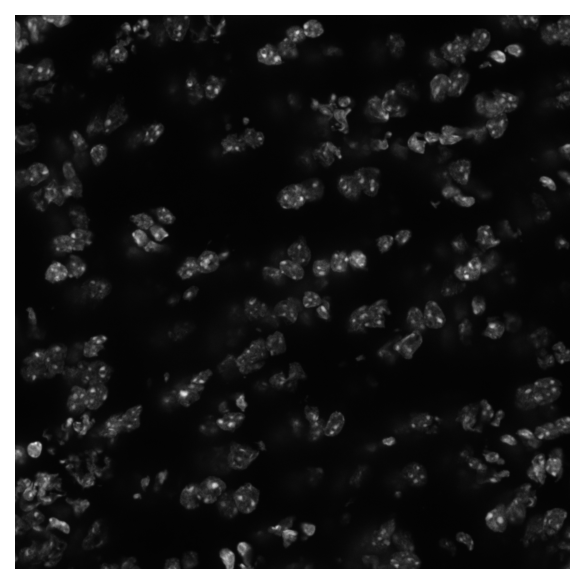

In [23]:

from starfish.util.plot import imshow_plane
from starfish.types import Axes

r_max_projection = stack.reduce({Axes.ROUND}, func="max")
f = plt.figure(dpi=150)
imshow_plane(r_max_projection, sel={Axes.CH: 3, Axes.ZPLANE: 40})

### Registration

In [6]:
from starfish import image
from starfish.util.plot import imshow_plane
from starfish.types import Axes

projection = stack.reduce({Axes.CH, Axes.ZPLANE}, func="max")
reference_image = projection.sel({Axes.ROUND: 0})

ltt = image.LearnTransform.Translation(
    reference_stack=reference_image,
    axes=Axes.ROUND,
    upsampling=1000,
)
transforms = ltt.run(projection)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 35.79it/s]


In [7]:
from pprint import pprint

pprint([t[2].translation for t in transforms.transforms])

[array([0., 0.]), array([-63.67 ,  21.703])]


In [8]:
transforms

tile indices: {<Axes.ROUND: 'r'>: 0}
translation: y=0.0, x=0.0, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 1}
translation: y=-63.67, x=21.703, rotation: 0.0, scale: 1.0

In [9]:
projection = stack.reduce({Axes.CH, Axes.ZPLANE}, func="max")
warp = image.ApplyTransform.Warp()
stack = warp.run(
    stack=stack,
    transforms_list=transforms,
)

In [11]:
stack.to_multipage_tiff(os.path.join(work_dir, "transformed/transformed.tiff"))

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 38.95it/s]


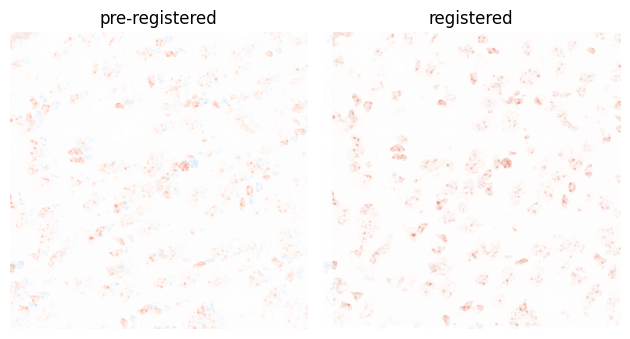

In [13]:
from starfish.util.plot import diagnose_registration
import matplotlib.pyplot as plt 

post_projection = stack.reduce({Axes.ZPLANE, Axes.CH}, func="max")

f, (ax1, ax2) = plt.subplots(ncols=2)
sel_0 = {Axes.ROUND: 0}
sel_1 = {Axes.ROUND: 1}
diagnose_registration(
    projection, sel_0, sel_1, ax=ax1, title='pre-registered'
)
diagnose_registration(
    post_projection, sel_0, sel_1, ax=ax2, title='registered'
)
f.tight_layout()

### Equalizing channel intensities (scaling)

In [3]:
#Load the transformed stack
from starfish import ImageStack
import tifffile
from tifffile import TiffFile

stack = ImageStack.from_numpy(tifffile.imread(os.path.join(work_dir, "transformed/transformed.tiff")))


Calculating reference distribution...


100%|███████████████████████████████████████| 158/158 [00:00<00:00, 4477.67it/s]


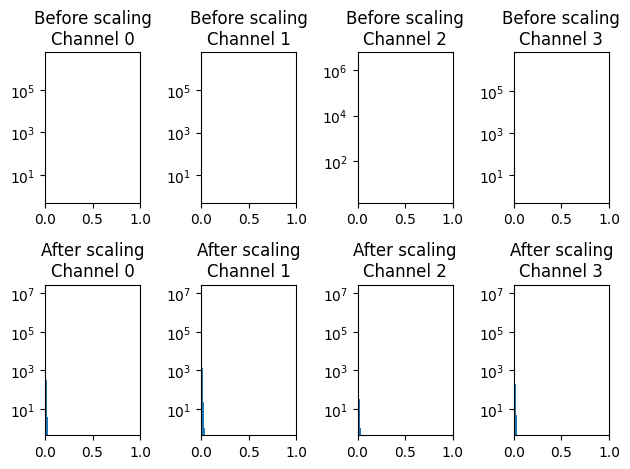

In [4]:
# Equalise channel intensities
from starfish import ImageStack
from starfish.util.plot import intensity_histogram
from starfish import image
from starfish.types import Axes
import matplotlib
import matplotlib.pyplot as plt


mh = image.Filter.MatchHistograms({Axes.CH, Axes.ROUND})
scaled = mh.run(stack, in_place=False, verbose=True, n_processes=8)

def plot_scaling_result(
    template: ImageStack, scaled: ImageStack
):
    f, (before, after) = plt.subplots(ncols=4, nrows=2)
    for channel, ax in enumerate(before):
        title = f'Before scaling\nChannel {channel}'
        intensity_histogram(
            template, sel={Axes.CH: channel, Axes.ROUND: 0}, ax=ax, title=title,
            log=True, bins=50,
        )
        ax.set_xlim((0, 1))
    for channel, ax in enumerate(after):
        title = f'After scaling\nChannel {channel}'
        intensity_histogram(
            scaled, sel={Axes.CH: channel, Axes.ROUND: 0}, ax=ax, title=title,
            log=True, bins=50,
        )
        ax.set_xlim((0, 1))
    f.tight_layout()
    return f

f = plot_scaling_result(stack, scaled)

In [ ]:
scaled.to_multipage_tiff(os.path.join(work_dir, "scaled/scaled.tiff"))

In [ ]:
#Adjustion of brightness and contrast?

In [ ]:
# Image registration (global) – Fourier transform + max. correlation

In [ ]:
# Non-rigid registration – further alignment of images in diff. seq rounds

### Spot calling

In [1]:
#Load the scaled stack
from starfish import ImageStack
import tifffile
from tifffile import TiffFile

stack = ImageStack.from_numpy(tifffile.imread(os.path.join(work_dir, "scaled/scaled.tiff")))


In [2]:
# Spot calling – find local maxima in 3D, Laplacian of Gaussian (LoG)
import numpy as np
from starfish.spots import FindSpots

bd = FindSpots.BlobDetector(
    min_sigma=1,
    max_sigma=8,
    num_sigma=10,
    threshold=np.percentile(np.ravel(stack.xarray.values), 95),
    exclude_border=2)

spots = bd.run(stack)

100%|██████████| 632/632 [00:04<00:00, 149.27it/s]


: 

In [ ]:
# Spot decoding – take maximum intensity channel of dots, remove spots if not matching codebook or too close to another code

In [ ]:
# Barcode filtering – filtering based on quality score, remove if mixture of channels instead of one

In [ ]:
# Inspection of results

## Cell identification

In [ ]:
# Cell segmentation

In [ ]:
# Extract expression matrix

## TREX pipeline for clone calling

In [ ]:
# Extract cloneIDs and cells with at least one cloneID

In [ ]:
# Filtering steps

In [ ]:
# Clone calling

In [ ]:
# Extract output files

## What to do with output data?

Lorem ipsum blabla